In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, entropy
from sklearn.tree import export_graphviz
from IPython.display import Image

from UtilFunctions import format_season
from UtilCollections import STATS_MAPPER, COLOR_MAPPER

In [2]:
df = pd.read_csv('closest_seasons.csv')
df = df.transpose()
df.index = df.index.astype(int)

In [3]:
def pre_process(seasons):
    df = None
    for season in seasons:
        per_min_cols = ['FGA', '3PA', '2PA', 'PF', 'PTS', 'OWS', 'DWS', 'OBPM', 'DBPM', 'BPM']
        cols_to_drop = None
        first_year, second_year = format_season(season)
        player_data = pd.read_csv(f"DataCollection/Player_Stats/player_stats_{first_year}-{second_year}.csv")
        cols_to_drop = ['index', 'TRB', 'DRB', 'ORB', 'AST', 'G', 'GS', 'FT', 'FG', 'FG%', 'BLK', 'STL',
                                'WS', 'FTA', 'TOV', 'Age', '2P', '3P', 'VORP']
            
        player_data = player_data.fillna(0)
        player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
        player_data = player_data.sort_values(by=['G'], ascending=False)
        player_data = player_data[player_data["Tm"] != "TOT"]
        player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
        player_data.reset_index(inplace=True)
        player_data.drop(columns=cols_to_drop, inplace=True)
        
        for col in per_min_cols:
            player_data[col] = player_data[col] / player_data['MP'] * 36
        
        if df is None:
            df = player_data
        else:
            df = pd.concat([df, player_data])
            
    df.reset_index(inplace=True)
    df.drop(['index', 'Player', 'Tm'], axis=1, inplace=True)
    return df

In [4]:
#teste de normalizar features
def random_forest_classify(X_train, y_train):
    rf = RandomForestClassifier()
    rand_search = RandomizedSearchCV(rf, param_distributions = {'n_estimators': randint(50,500), 'max_depth': randint(1, 20)},
                                 n_iter = 5, cv = 5, random_state=42)
    rand_search.fit(X_train, y_train)
    return rand_search.best_estimator_

In [5]:
def plot_feature_importances(importances, estimators, features):
    fi = pd.Series(importances, index=features).sort_values(ascending=False)
    #std = np.std([tree.feature_importances_ for tree in estimators], axis=0)
    fig, ax = plt.subplots(figsize=(18, 18))
    ax.bar(fi.index, fi)
    ax.tick_params('x', labelrotation=90)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")

In [6]:
def train_test_split(season, training_seasons):
    train_df = pre_process(training_seasons)
    test_df = pre_process([season])
    return train_df.loc[:, ~train_df.columns.isin(['Pos'])], test_df.loc[:, ~test_df.columns.isin(['Pos'])], train_df['Pos'], test_df['Pos']

In [7]:
def calculate_probability_matrix(cm):
    prob_matrix = []
    for i in range(len(cm)):
        prob_matrix.append([])
        players_in_position = sum(cm[i,:])
        for j in range(len(cm)):
            prob_matrix[i].append(round(cm[i,j]/players_in_position, 2))
    
    return prob_matrix

In [8]:
def entropy_by_position(positions, p_matrix):
    entropies = {}
    i = 0
    for position in positions:
        entropies[position] = entropy(p_matrix[i])
        i += 1
    return entropies

In [9]:
def classify_year_by_year(seasons, amount_training_seasons=4):
    entropies_df = pd.DataFrame()
    f1_scores = pd.DataFrame()
    feature_importances = pd.DataFrame()
    for season in seasons.index:
        training_seasons = list(seasons.loc[season])
        
        if amount_training_seasons < len(training_seasons):
            training_seasons = training_seasons[:amount_training_seasons]
        
        X_train, X_test, y_train, y_test = train_test_split(season, training_seasons)
        
        rf = random_forest_classify(X_train, y_train)
        y_pred = rf.predict(X_test)
        labels = ["PG", "SG", "SF", "PF", "C"]
        cm = confusion_matrix(y_test, y_pred, labels=labels)
        prob_matrix = calculate_probability_matrix(cm)
        entropies_df[season] = entropy_by_position(labels, prob_matrix)
        f1_scores[season] = f1_score(y_test, y_pred, average='micro')
        fi = {k:v for k,v in zip(X_train.columns,rf.feature_importances_)}
        feature_importances[season] = fi
    
    return entropies_df, f1_scores, feature_importances

In [10]:
entropies_df, scores, feature_importances = classify_year_by_year(df, 3)

<Axes: >

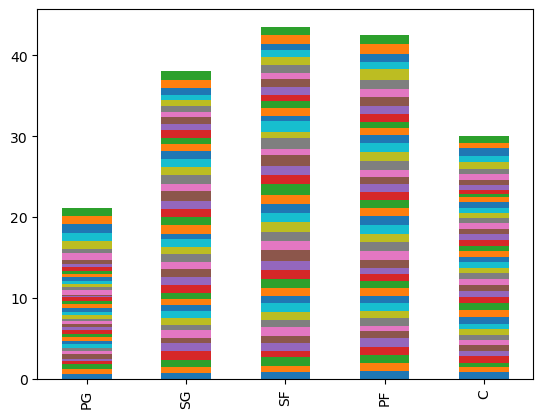

In [11]:
entropies_df.plot(kind='bar', stacked=True, legend=False)

<Axes: >

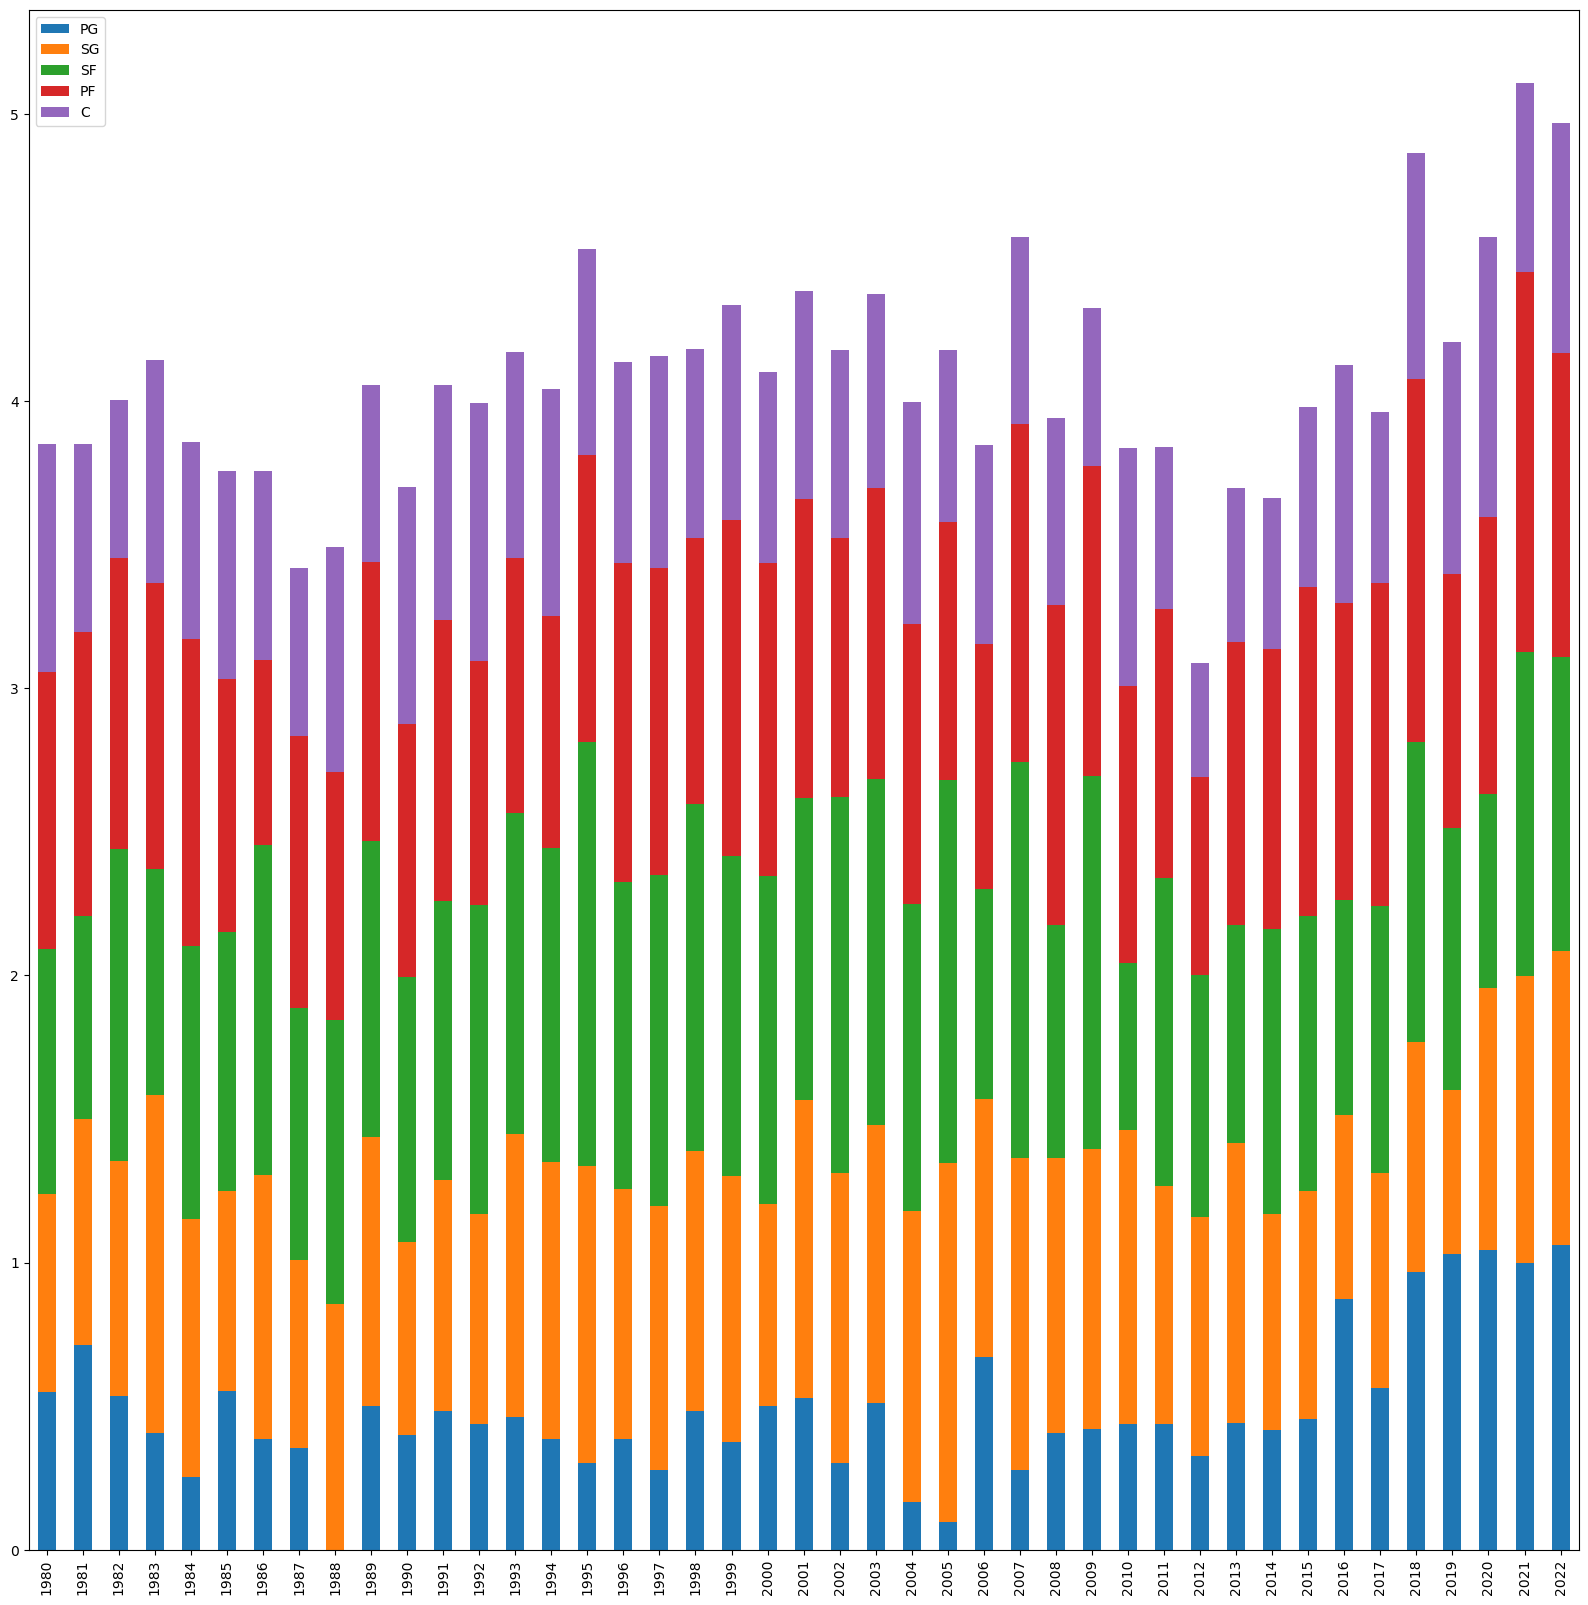

In [12]:
entropies_df.transpose().plot(kind='bar', stacked=True, figsize=(20,20))

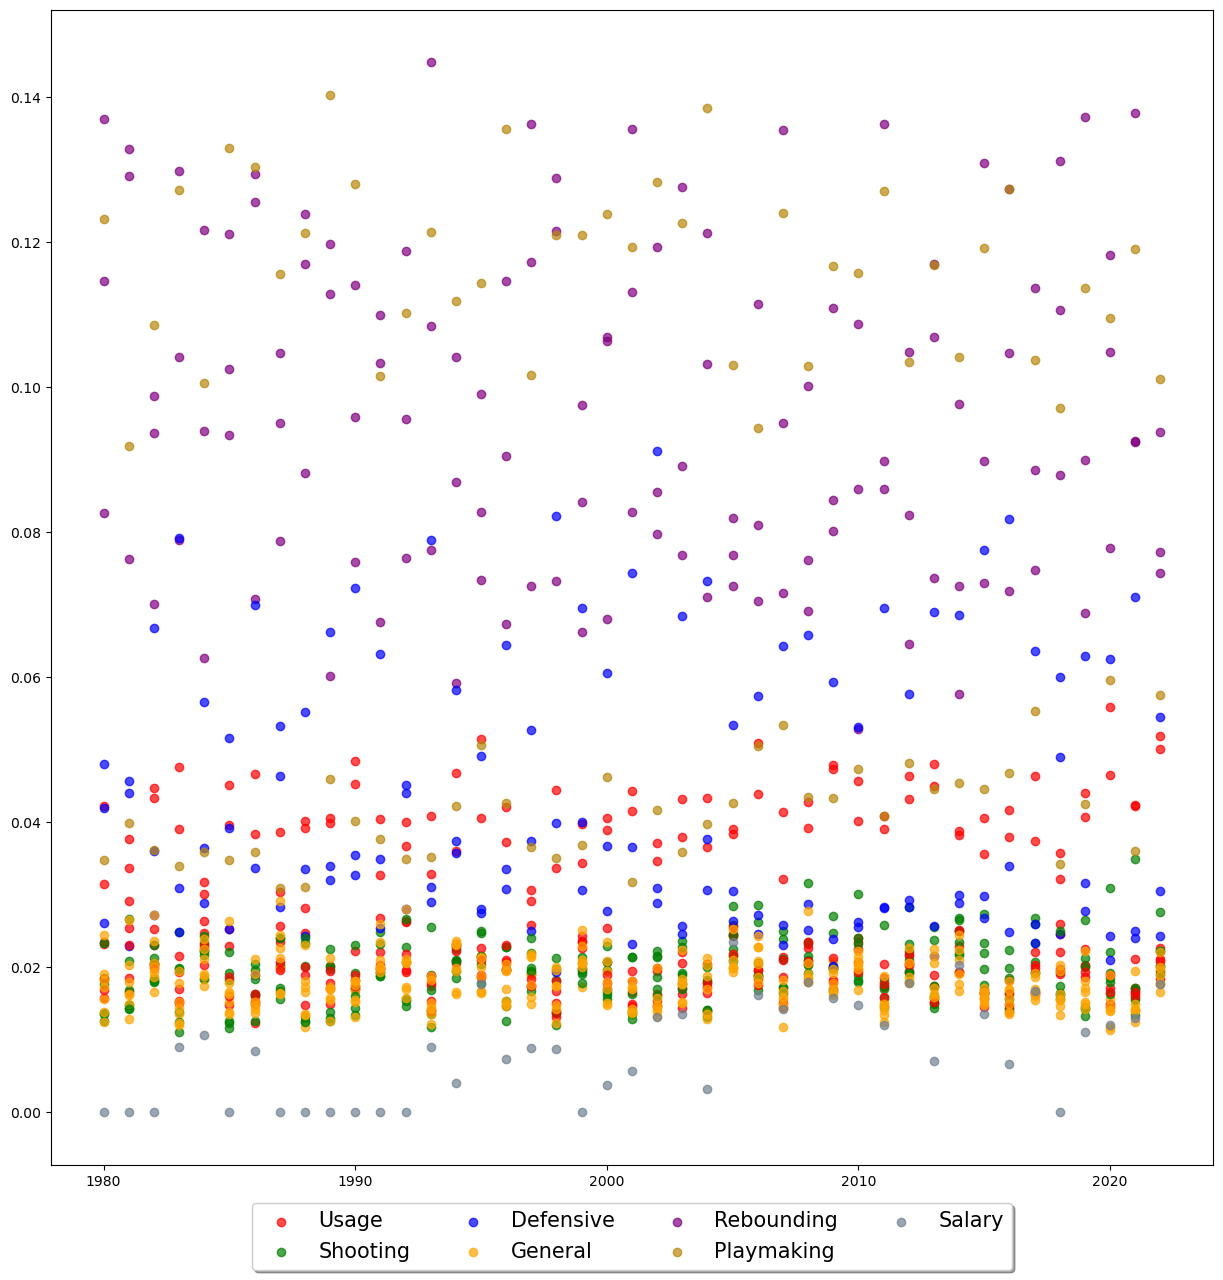

In [13]:
plt.figure(figsize=(15,15))

for idx in feature_importances.index:
    plt.scatter(feature_importances.columns, feature_importances.loc[idx], label=STATS_MAPPER[idx], color=COLOR_MAPPER[STATS_MAPPER[idx]], alpha=0.7)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),loc='lower center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4, prop={'size': 15})

plt.show()

## Run NullHypothesis notebook to find positionless borderlines

In [14]:
import nbformat
from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell

In [20]:
with open("NullHypothesisClassifier.ipynb", "r") as f:
    notebook = nbformat.read(f, as_version=4)

# Create an interactive shell
shell = InteractiveShell.instance()

# Execute each cell in the notebook
for cell in notebook.cells:
    if cell.cell_type == 'code':
        shell.run_cell(cell.source)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900


In [21]:
transposed_entropies = entropies_df.transpose()
positionless_markers = {}

for i, row in transposed_entropies.iterrows():
    positionless_markers[i] = {}
    for position in POSITIONS:
        if row[position] > positionless_borderlines[i][position]:
            positionless_markers[i][position] = True
        else:
            positionless_markers[i][position] = False

positionless_markers
    

{1980: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1981: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1982: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1983: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1984: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1985: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1986: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1987: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1988: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1989: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1990: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1991: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1992: {'PG': False, 'SG': False, 'SF': False, 'PF': False, 'C': False},
 1993: {'PG': False, 'SG': False, 'SF': False, 'PF'

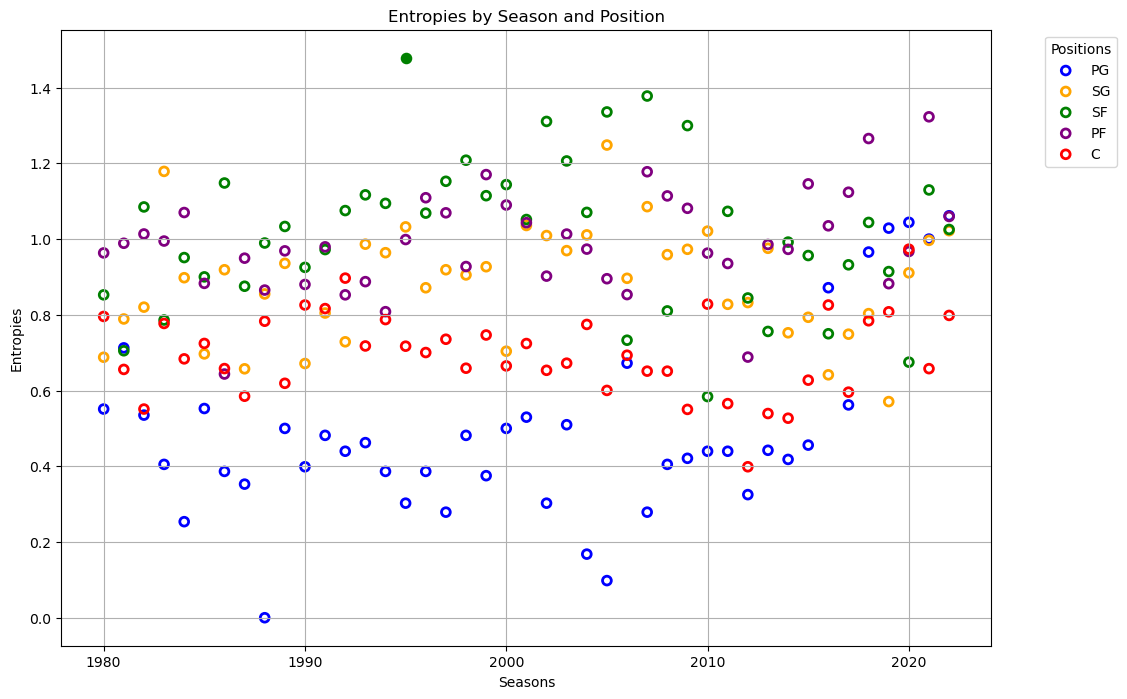

In [27]:
seasons = transposed_entropies.index
positions = transposed_entropies.columns

# Create the scatter plot
plt.figure(figsize=(12, 8))

for season in seasons:
    colors = {'PG': 'b', 'SG': 'orange', 'SF': 'g', 'PF': 'purple', 'C': 'r'}
    for position in positions:
        entropy = transposed_entropies.loc[season, position]
        fill_style = 'full' if positionless_markers[season][position] else 'none'
        
        plt.scatter(season, entropy, label=position, edgecolor=colors[position], facecolor=colors[position] if fill_style == 'full' else 'none', marker='o', s=40, lw=2)

# Customize the plot
plt.xlabel('Seasons')
plt.ylabel('Entropies')
plt.title('Entropies by Season and Position')
plt.legend(positions, title='Positions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()